In [1]:
!gdown --id 1p4UzQxFk5XHZFcTfsUL6oCLQxgEBY15Z

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1p4UzQxFk5XHZFcTfsUL6oCLQxgEBY15Z
To: /content/05_mrcnn_withKaggleNucleus.zip
100% 250M/250M [00:04<00:00, 60.1MB/s]


In [2]:
!unzip 05_mrcnn_withKaggleNucleus.zip

Archive:  05_mrcnn_withKaggleNucleus.zip
   creating: mrcnn_src/.ipynb_checkpoints/
  inflating: mrcnn_src/.ipynb_checkpoints/DataSet_custom-checkpoint.py  
  inflating: mrcnn_src/.ipynb_checkpoints/MaskRCNNTask-checkpoint.py  
  inflating: mrcnn_src/.ipynb_checkpoints/Run_find_MetaInfo-checkpoint.ipynb  
  inflating: mrcnn_src/.ipynb_checkpoints/Run_preprocessing_postprocessing-checkpoint.ipynb  
  inflating: mrcnn_src/.ipynb_checkpoints/Run_test-checkpoint.ipynb  
  inflating: mrcnn_src/.ipynb_checkpoints/Run_train-checkpoint.ipynb  
  inflating: mrcnn_src/.ipynb_checkpoints/Untitled-checkpoint.ipynb  
  inflating: mrcnn_src/.ipynb_checkpoints/Utils_custom-checkpoint.py  
   creating: mrcnn_src/__pycache__/
  inflating: mrcnn_src/__pycache__/DataSet_custom.cpython-35.pyc  
  inflating: mrcnn_src/__pycache__/DataSet_custom.cpython-37.pyc  
  inflating: mrcnn_src/__pycache__/MaskRCNNTask.cpython-35.pyc  
  inflating: mrcnn_src/__pycache__/MaskRCNNTask.cpython-37.pyc  
  inflating: mrcn

In [3]:
# 이미지 전처리 패키지
!pip install SimpleITK

     |████████████████████████████████| 48.4 MB 11 kB/s 


In [17]:
!pip uninstall h5py --yes
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 12.6 MB/s 


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### mask preprocessing

In [3]:
import os
import numpy as np
import cv2

In [6]:
%cd /content/mrcnn_src

/content/mrcnn_src


In [7]:
root_path = './data/mask_orgin/train'
save_path = './data/mask/train/nuclei'
for patient in os.listdir(root_path):
  img = cv2.imread('./data/Imgs/train/'+patient+'.png', cv2.IMREAD_GRAYSCALE)
  img = np.array(img, dtype = "int16")
  mask = np.zeros(img.shape)
  for m in os.listdir(os.path.join(root_path, patient)):
    mask_ = cv2.imread(os.path.join(root_path, patient, m), cv2.IMREAD_GRAYSCALE)
    mask_ = np.array(mask_, dtype = "int16")
    mask = mask+mask_
    mask[mask==255.] = 1
  cv2.imwrite(save_path+'/'+patient+'.png', mask)

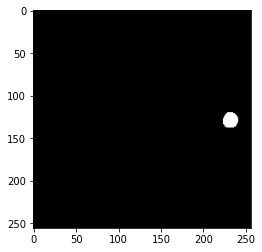

In [8]:
from matplotlib import pyplot as plt
plt.imshow(mask_, cmap='gray')

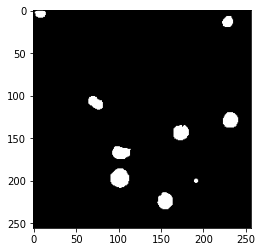

In [9]:
plt.imshow(mask, cmap='gray')

In [10]:
root_path = './data/mask_orgin/valid'
save_path = './data/mask/valid/nuclei'
for patient in os.listdir(root_path):
  img = cv2.imread('./data/Imgs/valid/'+patient+'.png', cv2.IMREAD_GRAYSCALE)
  img = np.array(img, dtype = "int16")
  mask = np.zeros(img.shape)
  for m in os.listdir(os.path.join(root_path, patient)):
    mask_ = cv2.imread(os.path.join(root_path, patient, m), cv2.IMREAD_GRAYSCALE)
    mask_ = np.array(mask_, dtype = "int16")
    mask = mask+mask_
    mask[mask==255.] = 1
  cv2.imwrite(save_path+'/'+patient+'.png', mask)

#### Setting Data config
Set the data path and class-list,   
and arrange the images in the path to prepare for training.

In [11]:
from DataSet_custom import Dataset

# dirname: class
Dirs = {'nuclei': 'nuclei'
        }

# class: id
Classes = {'nuclei' : 1
            }

train_imgPath = "./data/Imgs/train"
valid_imgPath = "./data/Imgs/valid"
train_maskPath = "./data/mask/train" 
valid_maskPath = "./data/mask/valid"

dataset_train = Dataset()
dataset_valid = Dataset()

Load roi-meta(.csv) and window-meta(.csv) for image pre-processing.

In [ ]:
# train_roi_csvFile = "/data/hdd1/Cardiomegaly/ACM_2/roi_train.csv"
# valid_roi_csvFile = "/data/hdd1/Cardiomegaly/ACM_2/roi_valid.csv"
# train_window_csvFile = "/data/hdd1/Cardiomegaly/ACM_2/window_train.csv"
# valid_window_csvFile = "/data/hdd1/Cardiomegaly/ACM_2/window_valid.csv"

Arrange data for training.

In [12]:
try:
    dataset_train.set_dataset(train_imgPath, train_maskPath, Dirs, Classes, train_roi_csvFile, train_window_csvFile)
    dataset_valid.set_dataset(valid_imgPath, valid_maskPath, Dirs, Classes, valid_roi_csvFile, valid_window_csvFile)
except NameError:
    # Window's csv or ROI's csv is not defined.
    dataset_train.set_dataset(train_imgPath, train_maskPath, Dirs, Classes)
    dataset_valid.set_dataset(valid_imgPath, valid_maskPath, Dirs, Classes)

class_info [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'xray', 'id': 1, 'name': 'nuclei'}]
class_info [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'xray', 'id': 1, 'name': 'nuclei'}]


#### Setting Model config & Training

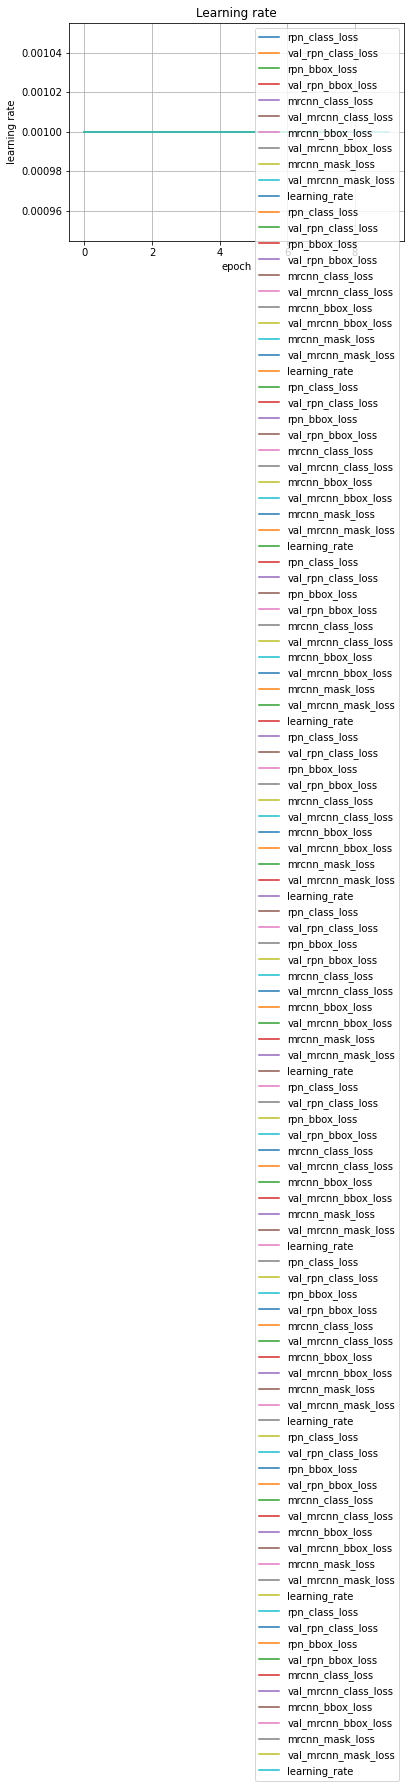

In [ ]:
# Training Code 
from DataSet_custom import ModelConfig
from SystemConfig import TaskID_Generator
from MaskRCNNTask import Train_DataSet
import os
import warnings

os.environ["CUDA_VISIBLE_DEVICES"]= '0'

modelConfig = ModelConfig(len(Classes))
modelConfig.EPOCHS = 10
# modelConfig.LEARNIING_MODE = "scratch"   # 완전 처음부터  A

# modelConfig.LEARNIING_MODE = "transfer"  # 밑에 경로의 weight를 이어 받아 계속 트레인 -> 밑에거랑 set      B
# modelConfig.PretainedModelPath = "/logs/Train_20200301_123219/xray20200301T1232/mask_rcnn_xray_0072.h5"   B

modelConfig.LEARNIING_MODE = "transfer-coco"                    # 얘네 둘 set     C
modelConfig.PretainedModelPath = "./logs/mask_rcnn_coco.h5"                      # C

logsPath = "./logs"
taskID = TaskID_Generator()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Train_DataSet(taskID, logsPath, modelConfig, dataset_train,  dataset_valid)

Model Test

In [ ]:
from MaskRCNNTask import Test_Dataset

In [ ]:
modelConfig.DETECTION_MIN_CONFIDENCE = 0.05 # 테스트할 때는 confience>0.05 인 결과 모두 출력.

In [ ]:
modelPath = "logs/Train_{}/MaskRCNN_{}.hdf5".format(taskID,taskID)
print ("Detection of "+taskID)

savePath = "logs/Test_{}".format(taskID)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Test_Dataset(savePath, modelConfig, modelPath, dataset_valid, \
                 saveFig = True, saveMask = True, saveEval = True, IoU_thr = 0)